# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

# Laboratório 14: Transfer Learning

## Importações e Configurações

In [1]:
import os
import torch
import zipfile
import requests
import numpy as np
import torch.nn as nn
from PIL import Image
from io import BytesIO
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Dados

In [2]:
if not os.path.exists('data/hymenoptera_data'):
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall("data/hymenoptera_data")
    print("Dataset 'hymenoptera_data' baixado e extraído.")
else:
    print("Dataset 'hymenoptera_data' já existe.")

Dataset 'hymenoptera_data' baixado e extraído.


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        self.data = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(class_dir, filename)
                    item = (path, self.class_to_idx[class_name])
                    self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data/hymenoptera_data'

# Criando instâncias de Dataset
train_dataset = CustomImageDataset(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = CustomImageDataset(os.path.join(data_dir, 'val'), data_transforms['val'])

# Criando instâncias de DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Obtendo informações
class_names = train_dataset.class_names
train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Classes: {class_names}")
print(f"Tamanho do dataset de treino: {train_size}")
print(f"Tamanho do dataset de validação: {val_size}")

Classes: ['ants', 'bees']
Tamanho do dataset de treino: 244
Tamanho do dataset de validação: 153


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Funções auxiliares

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            model.train(phase == 'train')
            running_loss, running_corrects = 0.0, 0
            size = len(loader.dataset)

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return history

In [6]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

## Modelo Baseline

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Movendo o modelo para o device
baseline_model = SimpleCNN().to(device)

# Otimizador e função de perda
criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)

In [9]:
# Treinando o modelo
history_baseline = train_model(
    baseline_model, criterion, optimizer_baseline, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25
Train Loss: 1.5178 Acc: 0.5615
Val Loss: 0.6919 Acc: 0.5294

Epoch 2/25
Train Loss: 0.6444 Acc: 0.6311
Val Loss: 0.5943 Acc: 0.6601

Epoch 3/25
Train Loss: 0.5799 Acc: 0.6516
Val Loss: 0.6940 Acc: 0.6471

Epoch 4/25
Train Loss: 0.6410 Acc: 0.6475
Val Loss: 0.6412 Acc: 0.6144

Epoch 5/25
Train Loss: 0.6012 Acc: 0.6803
Val Loss: 0.6173 Acc: 0.6797

Epoch 6/25
Train Loss: 0.5798 Acc: 0.6967
Val Loss: 0.6309 Acc: 0.6797

Epoch 7/25
Train Loss: 0.5825 Acc: 0.6680
Val Loss: 0.6639 Acc: 0.6078

Epoch 8/25
Train Loss: 0.5760 Acc: 0.7172
Val Loss: 0.5754 Acc: 0.7059

Epoch 9/25
Train Loss: 0.5595 Acc: 0.7254
Val Loss: 0.6178 Acc: 0.6797

Epoch 10/25
Train Loss: 0.5717 Acc: 0.6721
Val Loss: 0.5785 Acc: 0.7190

Epoch 11/25
Train Loss: 0.5340 Acc: 0.6967
Val Loss: 0.5822 Acc: 0.7386

Epoch 12/25
Train Loss: 0.5697 Acc: 0.7049
Val Loss: 0.6899 Acc: 0.6013

Epoch 13/25
Train Loss: 0.5848 Acc: 0.7377
Val Loss: 0.6710 Acc: 0.5752

Epoch 14/25
Train Loss: 0.5765 Acc: 0.7254
Val Loss: 0.5962

# Exercícios

## Exercício 1

Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [10]:
# Carregando o modelo ResNet-50 pré-treinado
resnet50_pretrained  = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Congelando todos os parâmetros
for param in resnet50_pretrained.parameters():
    param.requires_grad = False

# Substituindo a camada final
numero_de_features = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(numero_de_features, len(class_names))

# Descongelando o último bloco convolucional
for param in resnet50_pretrained.layer4.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [11]:
resnet50_pretrained = resnet50_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam([
    {'params': resnet50_pretrained.fc.parameters(), 'lr': 1e-3},      # LR alto para a nova camada (que substituiu a final)
    {'params': resnet50_pretrained.layer4.parameters(), 'lr': 1e-5}  # LR baixo para a layer4
], lr=1e-3) # LR padrão

In [12]:
history_resnet50 = train_model(
    resnet50_pretrained, criterion, optimizer_resnet50, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25
Train Loss: 0.5585 Acc: 0.7746
Val Loss: 0.3484 Acc: 0.9608

Epoch 2/25
Train Loss: 0.3750 Acc: 0.8811
Val Loss: 0.2236 Acc: 0.9673

Epoch 3/25
Train Loss: 0.3340 Acc: 0.8811
Val Loss: 0.1489 Acc: 0.9608

Epoch 4/25
Train Loss: 0.2801 Acc: 0.8770
Val Loss: 0.1359 Acc: 0.9673

Epoch 5/25
Train Loss: 0.2472 Acc: 0.9057
Val Loss: 0.1214 Acc: 0.9542

Epoch 6/25
Train Loss: 0.2776 Acc: 0.8689
Val Loss: 0.0962 Acc: 0.9739

Epoch 7/25
Train Loss: 0.2770 Acc: 0.8975
Val Loss: 0.1195 Acc: 0.9477

Epoch 8/25
Train Loss: 0.2516 Acc: 0.8975
Val Loss: 0.1176 Acc: 0.9673

Epoch 9/25
Train Loss: 0.2098 Acc: 0.9344
Val Loss: 0.0875 Acc: 0.9804

Epoch 10/25
Train Loss: 0.2146 Acc: 0.9139
Val Loss: 0.1007 Acc: 0.9673

Epoch 11/25
Train Loss: 0.2391 Acc: 0.8852
Val Loss: 0.1090 Acc: 0.9608

Epoch 12/25
Train Loss: 0.2110 Acc: 0.9098
Val Loss: 0.0895 Acc: 0.9739

Epoch 13/25
Train Loss: 0.1869 Acc: 0.9303
Val Loss: 0.1068 Acc: 0.9673

Epoch 14/25
Train Loss: 0.2164 Acc: 0.9139
Val Loss: 0.1094

## Exercício 2

Escolha outro modelo pré-treinado em [Torchvision Models](https://docs.pytorch.org/vision/main/models.html) e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [13]:
googlenet_pretrained = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

for param in googlenet_pretrained.parameters():
    param.requires_grad = False

numero_de_features = googlenet_pretrained.fc.in_features
googlenet_pretrained.fc = nn.Linear(numero_de_features, len(class_names))

for param in googlenet_pretrained.inception5b.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 174MB/s]


In [14]:
googlenet_pretrained = googlenet_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam([
    {'params': googlenet_pretrained.fc.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.inception5b.parameters(), 'lr': 1e-5}
], lr=1e-3)

In [15]:
history_googlenet = train_model(
    googlenet_pretrained, criterion, optimizer_googlenet, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25
Train Loss: 0.6526 Acc: 0.6434
Val Loss: 0.4189 Acc: 0.9216

Epoch 2/25
Train Loss: 0.5448 Acc: 0.7131
Val Loss: 0.3263 Acc: 0.9216

Epoch 3/25
Train Loss: 0.4809 Acc: 0.7664
Val Loss: 0.3659 Acc: 0.8627

Epoch 4/25
Train Loss: 0.4387 Acc: 0.8074
Val Loss: 0.2313 Acc: 0.9346

Epoch 5/25
Train Loss: 0.4004 Acc: 0.8361
Val Loss: 0.2412 Acc: 0.9216

Epoch 6/25
Train Loss: 0.3952 Acc: 0.8320
Val Loss: 0.2293 Acc: 0.9346

Epoch 7/25
Train Loss: 0.3736 Acc: 0.8402
Val Loss: 0.2463 Acc: 0.9281

Epoch 8/25
Train Loss: 0.5664 Acc: 0.7377
Val Loss: 0.2203 Acc: 0.9216

Epoch 9/25
Train Loss: 0.3501 Acc: 0.8484
Val Loss: 0.2202 Acc: 0.9216

Epoch 10/25
Train Loss: 0.3731 Acc: 0.8156
Val Loss: 0.2535 Acc: 0.9150

Epoch 11/25
Train Loss: 0.4009 Acc: 0.8033
Val Loss: 0.2067 Acc: 0.9281

Epoch 12/25
Train Loss: 0.4251 Acc: 0.8033
Val Loss: 0.2070 Acc: 0.9150

Epoch 13/25
Train Loss: 0.3779 Acc: 0.8566
Val Loss: 0.1985 Acc: 0.9281

Epoch 14/25
Train Loss: 0.4251 Acc: 0.8033
Val Loss: 0.2027

## Comparação dos Plots

Plots Baseline


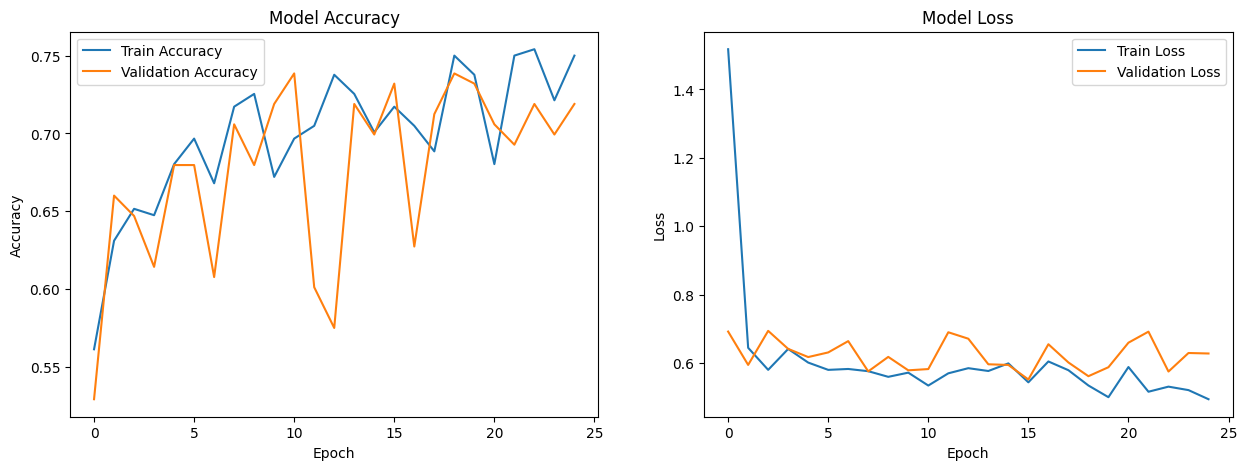

Plots ResNet50


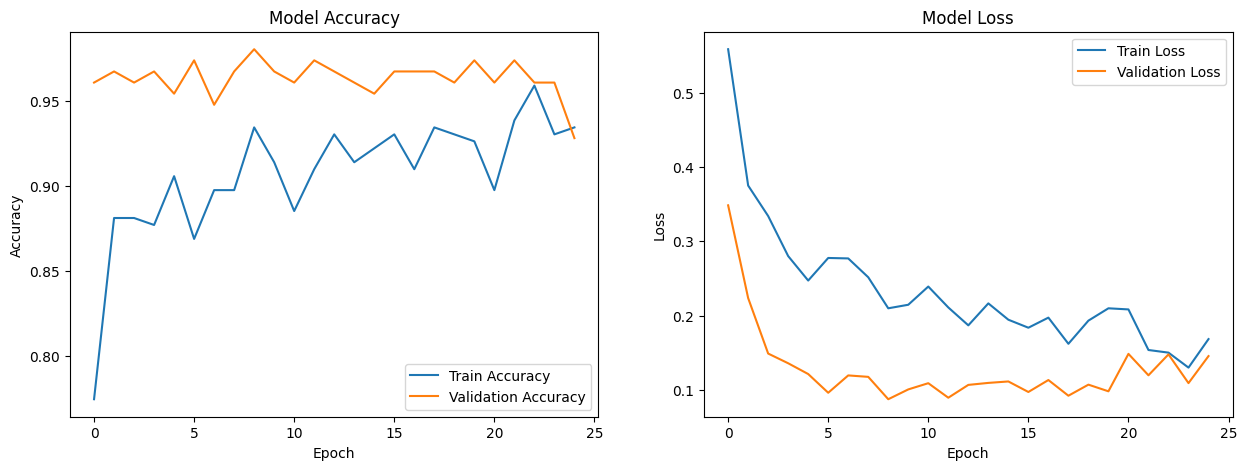

Plots GoogLeNet


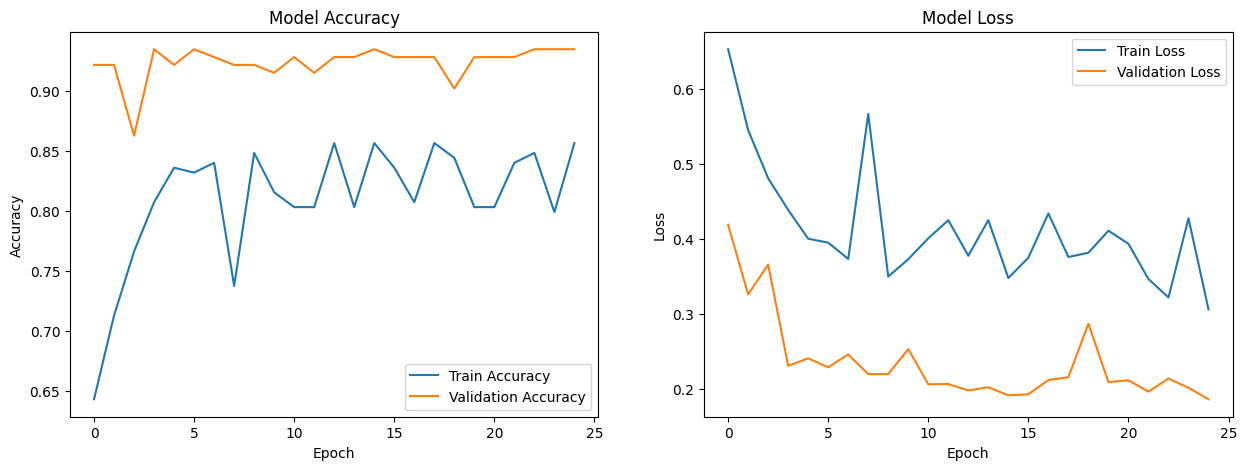

In [16]:
print(f"Plots Baseline")
plot_history(history_baseline)

print(f"Plots ResNet50")
plot_history(history_resnet50)

print(f"Plots GoogLeNet")
plot_history(history_googlenet)